In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import random
import yaml
from omegaconf import DictConfig, OmegaConf
from interventions import three_operands
from tqdm.notebook import tqdm
import numpy as np
from functools import partial

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer
import transformer_lens.patching as patching
import seaborn as sns
import matplotlib.pyplot as plt

from llm_transparency_tool.models.tlens_model import TransformerLensTransparentLlm
from llm_transparency_tool.models.transparent_llm import ModelInfo
from llm_transparency_tool.routes.graph import GraphBuilder, build_full_graph, build_paths_to_predictions
import networkx as nx

seed = 0

In [2]:
random.seed(seed)
torch.manual_seed(seed)
torch.set_grad_enabled(False)

In [3]:
# model_name = 'EleutherAI/pythia-12b-deduped-v0'
# model_name_lens = 'pythia-12b-deduped-v0'
# model_name = 'EleutherAI/pythia-6.9b-deduped-v0'
# model_name_lens = 'pythia-6.9b-deduped-v0'
# model_name = 'facebook/opt-1.3b'
# model_name_lens = 'opt-1.3b'
# model_name = 'openai-community/gpt2'
# model_name_lens = 'gpt2'
model_name = 'facebook/opt-6.7b'
model_name_lens = 'opt-6.7b'

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = TransformerLensTransparentLlm(
    model_name = model_name_lens,
    device='gpu'
)

/home/scratch_local/esx208-853860/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
dataset = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/my_perturbations_data_pythia_12b/base_data_arabic_pythia_12b.pkl')

dataset_strings_w_icl = [
    item.few_shots + item.base_string for item in dataset
]

/tmp/ipykernel_3366406/2430183916.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/my_perturbations_

In [51]:
threshold = 0.023
# msg = 'When Mary and John went to the store, John gave a drink to'
msg = '7 = 2 + 5. 5 + 6 ='
model.run(msg)
graph = build_full_graph(model, renormalizing_threshold=threshold)

tokens = model.tokens()[0]
n_tokens = tokens.shape[0]
model_info = model.model_info()

paths = build_paths_to_predictions(
    graph,
    model_info.n_layers,
    n_tokens,
    range(n_tokens),
    threshold,
)

2024-11-26 17:06:05.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 17:06:05.315 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 17:06:05.315 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 17:06:05.316 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 17:06:05.317 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 17:06:05.318 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 17:06:05.319 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-26 17:06:05.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [52]:
paths

In [53]:
# graphs = []
# for item in dataset_strings_w_icl:
#     transparent_pythia.run(item)
#     graphs.append(build_full_graph(transparent_pythia, renormalizing_threshold=0.04))
#     break

In [54]:
def set_positions(graph):
    positions = {}
    for node in graph.nodes:
        x_pos =  int(node.split('_')[1])
        y_pos = int(node.split('_')[0][1:])
        label = node.split('_')[0][0]
        if label == 'A':
            y_pos -= 0.3
        elif label == 'M':
            x_pos += 0.3
        elif label == 'I':
            y_pos += 0.3
        elif label == 'X':
            y_pos -= 1
        positions[node] = [x_pos, y_pos]
    return positions

positions = set_positions(graph)

In [55]:
# positions = {node: [int(node.split('_')[1]), int(node.split('_')[0][1:])] for node in graph.nodes}
# positions

In [56]:
len(tokenizer.tokenize(msg))

10

In [57]:
tokenizer.tokenize(msg)

['7', 'Ġ=', 'Ġ2', 'Ġ+', 'Ġ5', '.', 'Ġ5', 'Ġ+', 'Ġ6', 'Ġ=']

In [58]:
import matplotlib.pyplot as plt

plt.show()

([<matplotlib.axis.XTick at 0x7f1395f0fdc0>,
 [Text(0, 0, '<endoftext>'),
  Text(1, 0, '7'),
  Text(2, 0, 'Ġ='),
  Text(3, 0, 'Ġ2'),
  Text(4, 0, 'Ġ+'),
  Text(5, 0, 'Ġ5'),
  Text(6, 0, '.'),
  Text(7, 0, 'Ġ5'),
  Text(8, 0, 'Ġ+'),
  Text(9, 0, 'Ġ6'),
  Text(10, 0, 'Ġ=')])

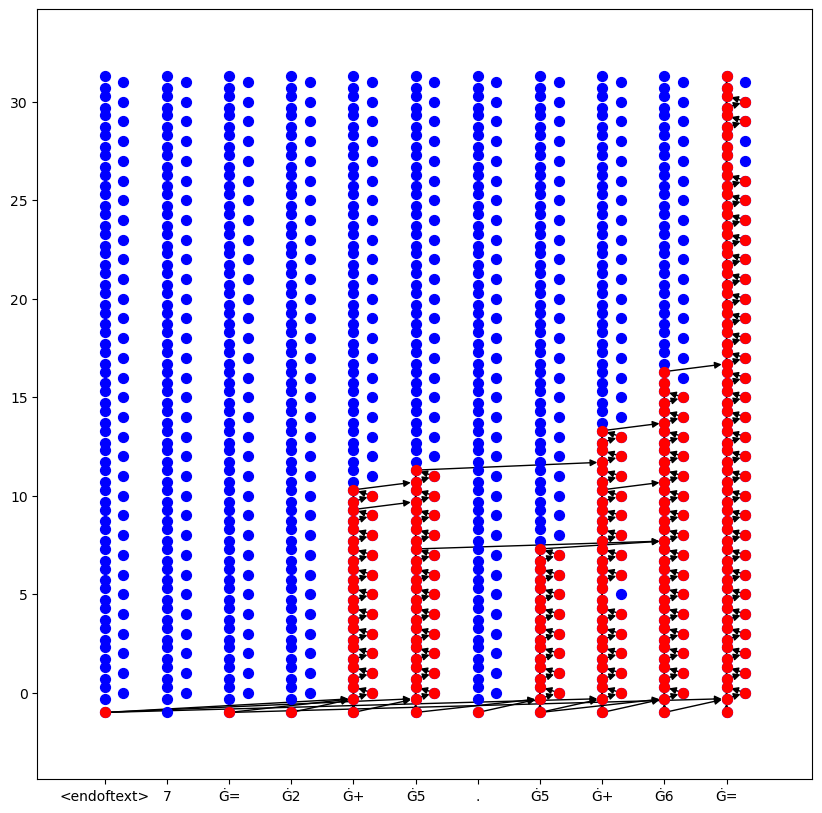

In [59]:
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(graph, node_color='blue', pos=positions, node_size=50)
nx.draw(paths[-1], node_color='red', pos=positions, node_size=50)
# for path in paths:
#     nx.draw(path, pos=positions)
# plt.xticks(ticks = range(len(tokenizer.tokenize(msg)) + 1), labels = ['<endoftext>'] + tokenizer.tokenize(msg))
# plt.axis("on")
# plt.show()

plt.axis("on")
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(ticks = range(len(tokenizer.tokenize(msg)) + 1), labels = ['<endoftext>'] + tokenizer.tokenize(msg))
# ax.set_xticklabels(tokenizer.tokenize(msg))

# # Extract the x and y positions of the nodes
# x_coords = [positions[n][0] for n in graph.nodes]
# y_coords = [positions[n][1] for n in graph.nodes]

# # Set ticks based on node positions
# plt.xticks(ticks=sorted(set(x_coords)), labels=[f"{x:.2f}" for x in sorted(set(x_coords))])
# plt.yticks(ticks=sorted(set(y_coords)), labels=[f"{y:.2f}" for y in sorted(set(y_coords))])

# # Turn on axis
# plt.axis("on")
# plt.grid(True)
# plt.show()

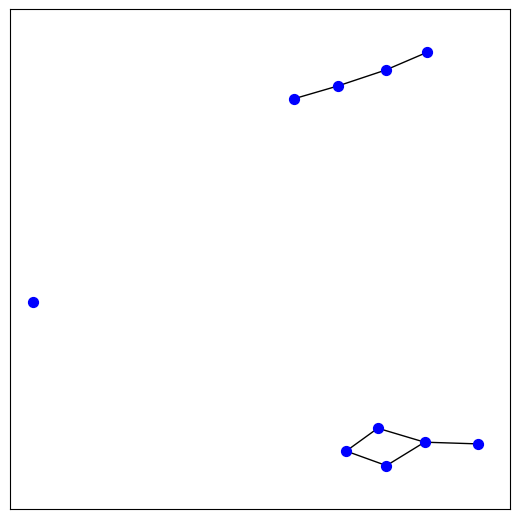

In [127]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a sample graph
G = nx.erdos_renyi_graph(10, 0.3)

# Generate positions for nodes
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(5, 5))
nx.draw(G, pos, node_color="blue", node_size=50, with_labels=False)

# Enable default axis ticks
plt.axis("on")  # Ensure the axis is turned on

# Show the plot
plt.show()

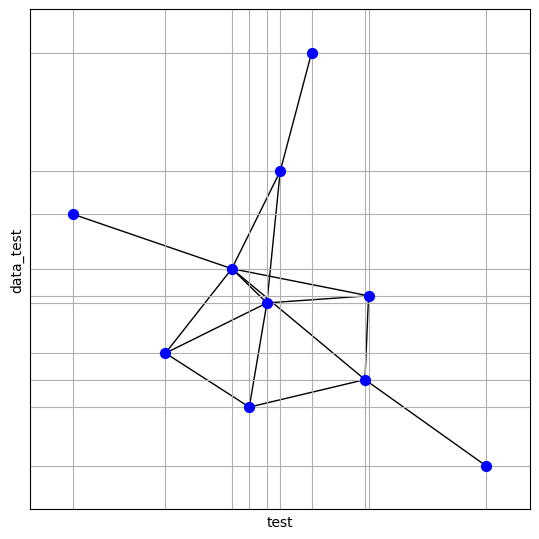

In [129]:
import networkx as nx
import matplotlib.pyplot as plt

# Example graph
G = nx.erdos_renyi_graph(10, 0.3)
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(5, 5))
nx.draw(G, pos, node_color="blue", node_size=50, with_labels=False)

# Extract the x and y positions of the nodes
x_coords = [pos[n][0] for n in G.nodes]
y_coords = [pos[n][1] for n in G.nodes]

# Set ticks based on node positions
plt.xticks(ticks=sorted(set(x_coords)), labels=[f"{x:.2f}" for x in sorted(set(x_coords))])
plt.yticks(ticks=sorted(set(y_coords)), labels=[f"{y:.2f}" for y in sorted(set(y_coords))])

plt.xlabel('test')
plt.ylabel('data_test')

# Turn on axis
plt.axis("on")
plt.grid(True)
plt.show()

In [125]:
x_coords

[0,
 0,
 0.3,
 1,
 1,
 1.3,
 2,
 2,
 2.3,
 3,
 3,
 3.3,
 4,
 4,
 4.3,
 5,
 5,
 5.3,
 6,
 6,
 6.3,
 7,
 7,
 7.3,
 8,
 8,
 8.3,
 9,
 9,
 9.3,
 10,
 10,
 10.3,
 0,
 0,
 0.3,
 1,
 1,
 1.3,
 2,
 2,
 2.3,
 3,
 3,
 3.3,
 4,
 4,
 4.3,
 5,
 5,
 5.3,
 6,
 6,
 6.3,
 7,
 7,
 7.3,
 8,
 8,
 8.3,
 9,
 9,
 9.3,
 10,
 10,
 10.3,
 0,
 0,
 0.3,
 1,
 1,
 1.3,
 2,
 2,
 2.3,
 3,
 3,
 3.3,
 4,
 4,
 4.3,
 5,
 5,
 5.3,
 6,
 6,
 6.3,
 7,
 7,
 7.3,
 8,
 8,
 8.3,
 9,
 9,
 9.3,
 10,
 10,
 10.3,
 0,
 0,
 0.3,
 1,
 1,
 1.3,
 2,
 2,
 2.3,
 3,
 3,
 3.3,
 4,
 4,
 4.3,
 5,
 5,
 5.3,
 6,
 6,
 6.3,
 7,
 7,
 7.3,
 8,
 8,
 8.3,
 9,
 9,
 9.3,
 10,
 10,
 10.3,
 0,
 0,
 0.3,
 1,
 1,
 1.3,
 2,
 2,
 2.3,
 3,
 3,
 3.3,
 4,
 4,
 4.3,
 5,
 5,
 5.3,
 6,
 6,
 6.3,
 7,
 7,
 7.3,
 8,
 8,
 8.3,
 9,
 9,
 9.3,
 10,
 10,
 10.3,
 0,
 0,
 0.3,
 1,
 1,
 1.3,
 2,
 2,
 2.3,
 3,
 3,
 3.3,
 4,
 4,
 4.3,
 5,
 5,
 5.3,
 6,
 6,
 6.3,
 7,
 7,
 7.3,
 8,
 8,
 8.3,
 9,
 9,
 9.3,
 10,
 10,
 10.3,
 0,
 0,
 0.3,
 1,
 1,
 1.3,
 2,
 2,
 2.3,
 3,
 3,
 3.3,
 4

/tmp/ipykernel_1310984/2503992601.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['C','B','A'])


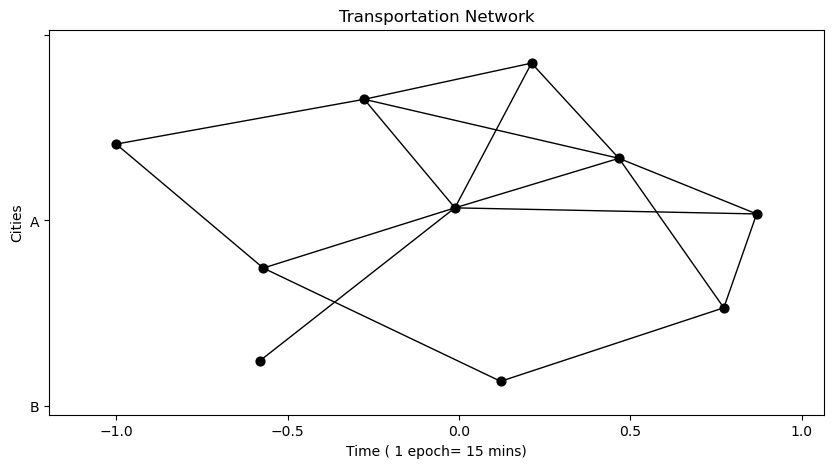

In [131]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Transportation Network')
#nx.draw_networkx_labels(GR, pos_dict)
g = nx.erdos_renyi_graph(10, 0.3)
nx.draw(g, node_size=40, node_color='black', ax=ax)
plt.xlabel('Time ( 1 epoch= 15 mins)')
plt.ylabel("Cities")
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_yticklabels(['C','B','A'])
plt.locator_params(axis="y", nbins=3)

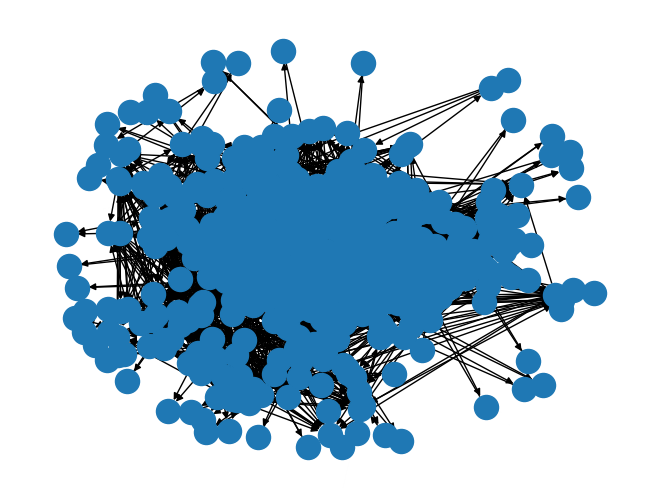

In [62]:
plt.figure()
nx.draw(graphs[0])
plt.show()

In [23]:
help(nx.draw)

Help on function draw in module networkx.drawing.nx_pylab:

draw(G, pos=None, ax=None, **kwds)
    Draw the graph G with Matplotlib.
    
    Draw the graph as a simple representation with no node
    labels or edge labels and using the full Matplotlib figure area
    and no axis labels by default.  See draw_networkx() for more
    full-featured drawing that allows title, axis labels etc.
    
    Parameters
    ----------
    G : graph
        A networkx graph
    
    pos : dictionary, optional
        A dictionary with nodes as keys and positions as values.
        If not specified a spring layout positioning will be computed.
        See :py:mod:`networkx.drawing.layout` for functions that
        compute node positions.
    
    ax : Matplotlib Axes object, optional
        Draw the graph in specified Matplotlib axes.
    
    kwds : optional keywords
        See networkx.draw_networkx() for a description of optional keywords.
    
    Examples
    --------
    >>> G = nx.dodecahe